In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import optuna


# BINARIO

In [7]:
X_train =pd.read_parquet("data/X_train_completo.parquet")
X_test= pd.read_parquet("data/X_test_completo.parquet")
y_train=pd.read_parquet("data/y_train.parquet")
y_test=pd.read_parquet("data/y_test.parquet")

print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

(40257, 51) (17253, 51) (40257, 1) (17253, 1)


Vamos a crear una submuestra para que podamos correr mas rapido

In [26]:
sss=StratifiedShuffleSplit(n_splits=1 , test_size=0.2, random_state=42)

for first_index , subsample_index  in sss.split(X_train,y_train):
    X_train_subs=X_train.iloc[subsample_index]
    y_train_subs=y_train.iloc[subsample_index]

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel=trial.suggest_categorical('kernel',['linear','poly'])
    class_weight = trial.suggest_categorical('class_weight',[None,'balanced'])
    params={
        'C':C,
        'kernel':kernel,
        'class_weight':class_weight,
        'random_state':42
    }
    if kernel =='poly':
        params['degree']=trial.suggest_int('degree', 2, 4)
    model = make_pipeline(StandardScaler() , SVC(**params))
    score = cross_val_score(model , X_train_subs,y_train_subs , cv=3 ,scoring='f1' , n_jobs=10).mean()
    return score

storage_name = "sqlite:///" + "outputs/" + "optimization_lgbm.db"
study_name = "svc_optimizacion2"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)
study.optimize(objective , n_trials=15)

print("Mejores parámetros:")
print(study.best_params)
print("Mejor score:", study.best_value)

[I 2025-10-16 22:18:14,093] A new study created in RDB with name: svc_optimizacion2
[I 2025-10-16 22:18:21,252] Trial 0 finished with value: 0.8682347210436204 and parameters: {'C': 87.92397904754003, 'kernel': 'poly', 'class_weight': None, 'degree': 2}. Best is trial 0 with value: 0.8682347210436204.
[I 2025-10-16 22:18:28,371] Trial 1 finished with value: 0.8679022177938421 and parameters: {'C': 95.30384306394492, 'kernel': 'poly', 'class_weight': None, 'degree': 2}. Best is trial 0 with value: 0.8682347210436204.
[I 2025-10-16 22:18:32,047] Trial 2 finished with value: 0.7793613366797237 and parameters: {'C': 0.00590273115593624, 'kernel': 'poly', 'class_weight': None, 'degree': 4}. Best is trial 0 with value: 0.8682347210436204.
[I 2025-10-16 22:18:35,810] Trial 3 finished with value: 0.8899665741636423 and parameters: {'C': 0.0017080075569688652, 'kernel': 'linear', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.8899665741636423.
[I 2025-10-16 22:18:37,659] Trial 4 fin

Mejores parámetros:
{'C': 0.06004025818553797, 'kernel': 'linear', 'class_weight': None}
Mejor score: 0.8961084056994695


In [4]:
storage_name = "sqlite:///" + "outputs/" + "optimization_lgbm.db"
study = optuna.load_study(study_name='svc_optimizacion2',storage=storage_name)


In [5]:
study.best_params

{'C': 0.06004025818553797, 'kernel': 'linear', 'class_weight': None}

In [9]:
ssc=StandardScaler()
X_train_scaled = pd.DataFrame(ssc.fit_transform(X_train) , columns=X_train.columns , index=X_train.index)
X_test_scaled = pd.DataFrame(ssc.transform(X_test) , columns = X_test.columns , index= X_test.index)

In [12]:
study.best_params

{'C': 0.06004025818553797, 'kernel': 'linear', 'class_weight': None}

In [ ]:
SVC( **study.best_params)


In [11]:
model_svm = SVC(**study.best_params)
model_svm.fit(X_train_scaled , y_train )

c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,C,0.06004025818553797
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [13]:
y_pred = model_svm.predict(X_test_scaled)
y_pred

array([1, 1, 0, ..., 1, 1, 1], shape=(17253,))

## F1 SCORE

In [16]:
from sklearn.metrics import f1_score , recall_score , precision_score , accuracy_score , confusion_matrix
print(f"recall score : {recall_score(y_test , y_pred)}")
print(f"precision score : {precision_score(y_test , y_pred)}")
print(f"f1 score : {f1_score(y_test , y_pred)}")
print(f"accuracy score : {accuracy_score(y_test , y_pred)}")
print(f"matriz de confusion\n {confusion_matrix(y_test , y_pred)}")

recall score : 0.9172426676629927
precision score : 0.8595185995623632
f1 score : 0.8874429533233925
accuracy score : 0.8556193125833188
matriz de confusion
 [[4942 1605]
 [ 886 9820]]


## CURVA DE COMPLEJIDAD

In [17]:
np.arange(1,10,1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
best_params=study.best_params

In [23]:
best_params['kernel'] = 'poly'
scores_train = []
scores_test = []
for d in range(1,11):
    print("****************************")
    print(d)
    if d == 1 :
        best_params['kernel']  = 'linear'
    else:
        best_params['kernel']  ='poly'
    print(best_params)
    model_svm_i = SVC(**best_params)
    model_svm_i.fit(X_train_scaled , y_train)

    y_hat_train = model_svm_i.predict(X_train_scaled)

    y_hat_test = model_svm_i.predict(X_test_scaled)

    score_train = f1_score(y_train , y_hat_train)
    scores_train.append(score_train)

    score_test = f1_score(y_test , y_hat_test)
    scores_test.append(score_test)

****************************
1
{'C': 0.06004025818553797, 'kernel': 'linear', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
2
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
3
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
4
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
5
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
6
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
7
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
8
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
9
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************
10
{'C': 0.06004025818553797, 'kernel': 'poly', 'class_weight': None}


c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
[d for d in range(1,11)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

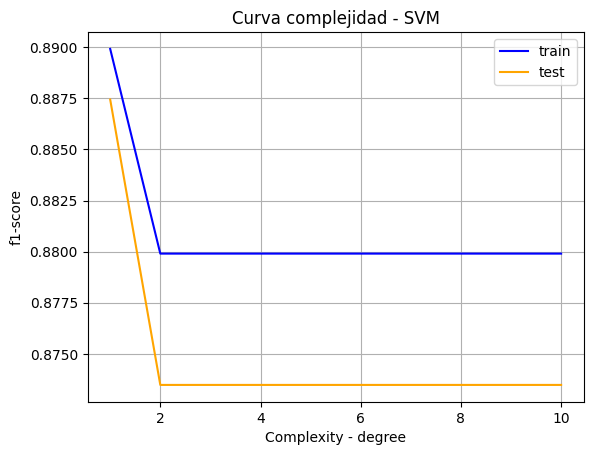

In [29]:
plt.plot([d for d in range(1,11)] , scores_train,color='blue',label="train")
plt.plot([d for d in range(1,11)] , scores_test,color='orange',label="test")
plt.legend()
plt.xlabel("Complexity - degree")
plt.ylabel("f1-score")
plt.title("Curva complejidad - SVM")
plt.grid(True)
plt.show()